# Questions from Exploratory Data Analysis on Docomo's Data
### By Shuyi Yin
This Jupyter Notebook file did these:
+ Processed the file in two passes, the second one recording necessary population flow information;<br>
+ In the second pass of data, we also sorted the data according to time;<br>
+ Answered specific exploratory questions;<br>
+ Wrote for each timestamp the demand matrix, in txt file and then in npz files;

## Load modules

In [1]:
import os
import csv
import time
import datetime
import numpy as np
import re
import json
from matplotlib import pyplot as plt
import folium
from folium.plugins.measure_control import MeasureControl
from decimal import Decimal
import scipy.sparse
from multiprocessing import Pool

## Defining functions
+ Convert trip time to half hours;
+ Plot number of visits temporal;
+ Locate bins index for self-managed barplot (histogram);
+ Some color and bolds of text

In [2]:
def toHalfHour(item):
    d = re.split(r'days',item.split()[0])[0]
    h, m, _ = item.split()[1].split(':')
    return int(d)*48 + int(h)*2 + round(float(m)/30)

def plotTemporalVisit(ID, start_day, end_day, spa_tem_visits):
    labels = np.arange(0,31,1)
    if ID == 'all':
        plt.plot(np.sum(spa_tem_visits, axis = 1))
    else:
        plt.plot(spa_tem_visits[:,meshIndDic[str(ID)]])
    plt.xticks(np.arange(0, spa_tem_visits.shape[0], 24*6), labels)
    plt.xlim((6*24*start_day,6*24*end_day))
    plt.xlabel('Day since collecting')
    plt.ylabel('Num. of ovement starts')
    plt.title('Movement start counts for {} mesh(es)'.format(str(ID)))
    plt.show()
    pass

def locate(key, bins):
    anchor = (np.abs(bins - int(key))).argmin()
    if int(key) >= anchor:
        return anchor
    else:
        return anchor - 1

class color:
   PURPLE = '\033[95m'
   CYAN = '\033[96m'
   DARKCYAN = '\033[36m'
   BLUE = '\033[94m'
   GREEN = '\033[92m'
   YELLOW = '\033[93m'
   RED = '\033[91m'
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   END = '\033[0m'

## A first full pass and information summary
Without recording population flow and trip duration.

In [ ]:
# count the number of time intervals - 10mins
interval_start = datetime.datetime.strptime('2018-05-01 0:00:00', '%Y-%m-%d %H:%M:%S')
interval_end = datetime.datetime.strptime('2018-05-31 23:50:00', '%Y-%m-%d %H:%M:%S')
interval_num = int((interval_end - interval_start).total_seconds() / (10*60))
# spa_tem_visits = np.zeros((interval_num+1, 1))
# spa_tem_visits

# store unique mesh ID
uMeshID = 0
meshIndDic = {}
meshLocDic = {}

# trip length
trip_length = {}

start = time.time()
with open('/path-to-file/trip_od_v3_201805.csv') as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')
    line_count = 0
    for row in csv_reader:
        if line_count == 0:
            print(", ".join(row))
            line_count += 1
        else:
            # if it is a new mesh, store and add a new column to the matrix
            if row[1] not in meshIndDic:
                uMeshID += 1
                meshIndDic[row[1]] = uMeshID - 1
                meshLocDic[row[1]] = (row[2], row[3])
                if uMeshID == 1:
                    spa_tem_visits = np.zeros((interval_num+1, 1))
                else:
                    newColumn = np.zeros((interval_num+1, 1))
                    spa_tem_visits = np.hstack((spa_tem_visits, newColumn))
            
            # update the count
            timeNow = int((datetime.datetime.strptime(row[0], '%Y-%m-%d %H:%M:%S') - interval_start).total_seconds() / (10*60))
            spa_tem_visits[timeNow, meshIndDic[row[1]]] += 1
            
            # store trip length
            if toHalfHour(row[-1]) in trip_length:
                trip_length[toHalfHour(row[-1])] += 1
            else:
                trip_length[toHalfHour(row[-1])] = 1
            
            # if toHalfHour(row[-1]) == 1039:
            #     print(row[-1])
            
            line_count += 1
            stop = time.time()
            if line_count % 10000000 == 0:
                print("{} lines took {} seconds.".format(line_count, round(stop-start)))
                # break
end = time.time()
print('Time(s) it took: ', round(end - start))

### Save summary information of first pass to local file

It tood **24464** seconds to process the whole file in the process specified above.

In [ ]:
np.savetxt('/Volumes/My Passport for Mac/spa_tem_visits.txt', spa_tem_visits)

In [ ]:
json = json.dumps(dict)
f = open("dict.json","w")
f.write(json)
f.close()

## A second pass that records population flow
#### We find that Python is not capable of doing such an operation. Spark DataFrame must be involved; we also applied Spark SQL to process the data.
+ Need to include population flow and trip duration.
+ Since data do not come in sorted time, need to have a file for each time step, which will just include write in.
+ Compile matrices from each text file.<br>

#### Honestly, this is really hard and we tried two days tuning this process. There are a lot of I/Os in writing out the file, so a significant amount of disk space is required, which can only be internal. Finally, <span style="background-color: #FFFF00">without coalesce(1)</span>, I succeded. Now the Spark dataframe is sorted and written to 200 files on external drive.
+ Removed transformation to timestamp format from string and transforming back before writing, so saved two steps of operation.
+ Decided the initial see-one-write-out-one is too time consuming; see calculation below: 472 hours.
+ Saved the hustle of 4416 steps of selecting of time and writing to individual files. Instead, did a sort and write out to files to save time. CSVs can be traversed faster in Python with some tricks.<br>

#### Plesease refer to file ***sortByTime.py*** as the Spark execution.

#### Iterating and writing data records to files takes so long a time
First $10^5$ entires were written to 4416 files, taking 243 seconds.<br>
So linearly projecting, rewriting all entries takes $\frac{5\times10^8}{10^5}*243=1,701,000\text{ seconds}=472.5\text{ hours}$

In [35]:
# count the number of time intervals - 10mins
interval_start = datetime.strptime('2018-05-01 0:00:00', '%Y-%m-%d %H:%M:%S')
interval_end = datetime.strptime('2018-05-31 23:50:00', '%Y-%m-%d %H:%M:%S')
interval_num = int((interval_end - interval_start).total_seconds() / (10*60))
print(interval_num)

start = time.time()

directory = '/path-to-file/'
with open('/path-to-file/trip_od_v3_201805.csv') as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')
    line_count = 0
    for row in csv_reader:
        if line_count == 0:
            print(", ".join(row))
            line_count += 1
        else:            
            # update the count
            timeNow = int((datetime.strptime(row[0], '%Y-%m-%d %H:%M:%S') - interval_start).total_seconds() / (10*60))
            file = open(directory + str(timeNow) + '.txt', 'a')
            # from where, to where, how many population, how long duration
            file.write(row[1] + ',' + row[5] + ',' + row[-2] + ',' + row[-1] + ',' + str(line_count) + '\n')
            file.close()
            
            line_count += 1
            stop = time.time()
            if line_count % 100000 == 0:
                print("{} lines took {} seconds.".format(line_count, round(stop-start)))
                # break
end = time.time()
print('Time(s) it took: ', round(end - start))

4463
org_date, org_mesh, org_lat, org_lng, dest_date, dest_mesh, dest_lat, dest_lng, trip_population, duration
100000 lines took 243 seconds.
Time(s) it took:  243


#### Try sorting the csv file by the time attribute
Cannot sort in one line command.<br>
Need to read in the CSV file by chunk and sort.

In [4]:
with open('/path-to-file/trip_od_v3_201805.csv') as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')
    count = 0
    for row in csv_reader:
        print(row)
        count += 1
        if count == 5:
            break

['org_date', 'org_mesh', 'org_lat', 'org_lng', 'dest_date', 'dest_mesh', 'dest_lat', 'dest_lng', 'trip_population', 'duration']
['2018-05-19 11:20:00', '533900944', '35.4125', '139.05625', '2018-05-20 03:10:00', '533900951', '35.4083333333333', '139.0625', '0.00155954518488357', '0days 15:50:00']
['2018-05-18 13:50:00', '533900944', '35.4125', '139.05625', '2018-05-19 03:20:00', '533901024', '35.3375', '139.15625', '0.00874432737327648', '0days 13:30:00']
['2018-05-12 06:00:00', '533900944', '35.4125', '139.05625', '2018-05-12 22:00:00', '533910042', '35.4166666666667', '139.05625', '0.0207291292994487', '0days 16:0:00']
['2018-05-13 17:20:00', '533900944', '35.4125', '139.05625', '2018-05-13 20:20:00', '533910042', '35.4166666666667', '139.05625', '0.0169008586514076', '0days 3:0:00']


## Answer specific questions

### Read mesh index dictionary data

In [4]:
# spa_tem_visits = np.loadtxt('/Volumes/My Passport for Mac/spa_tem_visits.txt')

# which column in spa_temp matrix the mesh corresponds to
with open('meshIndDic.json') as f:
    meshIndDic = json.load(f)
# locations of the mesh
with open('meshLocDic.json') as f:
    meshLocDic = json.load(f)
# trip lengths in half hours
with open('trip_length.json') as f:
    trip_length = json.load(f)

### Q1: what is population flow?

In [4]:
with open('/path-to-file/trip_od_v3_201805.csv') as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')
    line_count = 0
    maxPop = 0
    for row in csv_reader:
        if line_count == 0:
            print(", ".join(row))
            line_count += 1
        else:
            # print(row[-2])
            line_count += 1
            print(row[-2])
            if float(row[-2]) > maxPop:
                maxPop = float(row[-2])
            if line_count == 100:
                print(maxPop)
                break

org_date, org_mesh, org_lat, org_lng, dest_date, dest_mesh, dest_lat, dest_lng, trip_population, duration
0.00155954518488357
0.00874432737327648
0.0207291292994487
0.0169008586514076
0.0168514072551119
0.0186793402178509
0.00372958424578106
0.00945310295585152
0.0154314999720132
0.0152914949560158
0.000918521288092818
0.0124309711865304
0.0197139654281719
0.00410069325872243
0.000838665154466416
0.0230371472640038
0.0250663464157784
0.0187276727803535
0.0174226844530594
0.00101192137380598
0.0235399851574906
0.022887081182786
0.00974642450691743
1.2153892042051e-08
0.00792319668977298
0.0167089759607311
0.00416040706369409
1.10972340858634e-08
0.0133867974726372
0.0076122188478531
0.0108825784621408
0.0144662151289492
0.00484430350373837
0.00117916199624035
0.0069504134293094
0.00235559476353005
0.00753962434651494
0.00215079962960704
0.0463701239294905
0.0616612552745623
0.0455548199361736
0.068443327601488
2.3477264183019e-06
0.00173788191684645
0.0032766795095601
0.0124715922076815

### Q2: trip between a specific pair of meshes have multiple durations

In [17]:
travelTime = {}
with open('/path-to-file/trip_od_v3_201805.csv') as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')
    line_count = 0
    for row in csv_reader:
        if line_count == 0:
            print(", ".join(row))
            line_count += 1
        else:
            line_count += 1
            if (row[1], row[5]) not in travelTime:
                travelTime[(row[1], row[5])] = row
            else:
                # if toHalfHour(row[-1]) != travelTime[(row[1], row[5])]:
                    # print(travelTime[(row[1], row[5])], toHalfHour(row[-1]))
                if row != travelTime[(row[1], row[5])]:
                    print('\nA trip for a pair of meshes is \n', travelTime[(row[1], row[5])])
                    print('\n')
                    print('Another record for the same pair is \n', row)
                    print(color.BOLD + '\nClearly, the durations do not match: {} and {}.'.format(travelTime[(row[1], row[5])][-1], row[-1]) + color.END)
                    break

org_date, org_mesh, org_lat, org_lng, dest_date, dest_mesh, dest_lat, dest_lng, trip_population, duration

A trip for a pair of meshes is 
 ['2018-05-12 06:00:00', '533900944', '35.4125', '139.05625', '2018-05-12 22:00:00', '533910042', '35.4166666666667', '139.05625', '0.0207291292994487', '0days 16:0:00']


Another record for the same pair is 
 ['2018-05-13 17:20:00', '533900944', '35.4125', '139.05625', '2018-05-13 20:20:00', '533910042', '35.4166666666667', '139.05625', '0.0169008586514076', '0days 3:0:00']

Clearly, the durations do not match: 0days 16:0:00 and 0days 3:0:00.


### Q3: time distribution of counts
There are 31 days of data. The first day of data is May. 1st, 2018, a Tuesday.

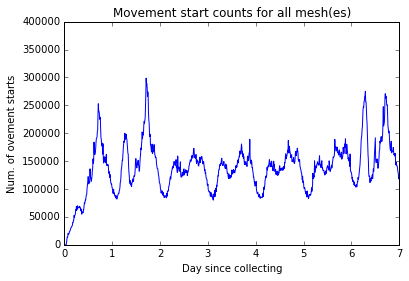

In [18]:
plotTemporalVisit('all', 0, 7, spa_tem_visits)

### Q3': when is the earliest and latest records?
Although Docomo claims the recording starts at <span style="background-color: #FFFF00">**"2018-05-01 00:00:00"**</span>, the actuall starting (minimum) records are at <span style="background-color: #FFFF00">**"2018-05-01 01:00:00"**</span>.<br>
We use **Spark SQL** to find the *minimum and maximum* of the timestamps:<br>
<span style="background-color: #FFFF00">2018-05-01 01:00:00</span><br>
<span style="background-color: #FFFF00">2018-05-31 22:20:00</span>

#### This is true since the first 5 timestamps are empty

In [29]:
np.sum(spa_tem_visits[-9:-1,:])

0.0

#### This is further proved by a search through the raw data

In [4]:
with open('/path-to-file/trip_od_v3_201805.csv') as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')
    line_count = 0
    for row in csv_reader:
        if line_count == 0:
            print(", ".join(row))
            line_count += 1
        else:
            line_count += 1
            if line_count % 10000000 == 0:
                print(line_count)
            
            if row[0] < "2018-05-01 01:00:00":
                print(row)
                break

org_date, org_mesh, org_lat, org_lng, dest_date, dest_mesh, dest_lat, dest_lng, trip_population, duration
10000000
20000000
30000000
40000000
50000000
60000000
70000000
80000000
90000000
100000000
110000000
120000000
130000000
140000000
150000000
160000000
170000000
180000000
190000000
200000000
210000000
220000000
230000000
240000000
250000000
260000000
270000000
280000000
290000000
300000000
310000000
320000000
330000000
340000000
350000000
360000000
370000000
380000000
390000000
400000000
410000000
420000000
430000000
440000000
450000000
460000000
470000000
480000000
490000000
500000000
510000000
520000000
530000000
540000000
550000000
560000000
570000000
580000000
590000000
600000000
610000000
620000000
630000000
640000000
650000000
660000000
670000000
680000000
690000000


### Q4: trip lengths; why are some super long while some super short?
There are 17444478 trips of length 0? <br>
Need to check if it's 10 minutes or 0 minutes though.

In [9]:
iDs = [item for item in list(trip_length.keys()) if float(item) < 1]
vals = [trip_length[iD] for iD in iDs]
print('The set of lengths that are shorter than a half hour: {}'.format(iDs))
print('Corresponding counts for the lengths that are shorter than one half hour: {}'.format(vals))
# plt.bar(iDs, vals)
# plt.show()

The set of lengths that are shorter than a half hour: ['0']
Corresponding counts for the lengths that are shorter than one half hour: [17444478]


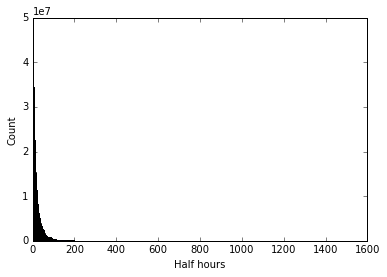

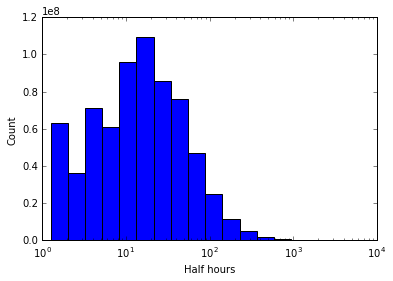

In [12]:
plt.figure(1)
plt.bar(trip_length.keys(), trip_length.values())
plt.xlabel('Half hours')
plt.ylabel('Count')

bins = np.logspace(0.1, 4, 20)
countVec = np.zeros(bins.shape)
for key in trip_length.keys():
    countVec[locate(key, bins)] += trip_length[key]
plt.figure(2)


plt.bar(bins[:-1], countVec[:-1], width = np.diff(bins))
# plt.xlim((1, 200))
plt.xlabel('Half hours')
plt.ylabel('Count')
plt.xscale('log')
plt.show()

#### Check manually for super short trips
+ See __short_0.html__ for the plotting of too short trips.<br>
+ Also wait and look closer as there are some problems with the super short trips.<br>

##### Plotting of super short trips

In [13]:
delLat = 0.0041666666667
delLon = 0.00625
tokyo = folium.Map(location=[35.6895, 139.6917], zoom_start=9)
c = MeasureControl()
c.add_to(tokyo)

count = 0
with open('/path-to-file/trip_od_v3_201805.csv') as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')
    line_count = 0
    for row in csv_reader:
        if line_count == 0:
            print(", ".join(row))
            line_count += 1
        else:
            points = []
            line_count += 1
            if toHalfHour(row[-1]) == 0:
                
                count += 1
                points.append(tuple([float(row[2]), float(row[3])]))
                points.append(tuple([float(row[6]), float(row[7])]))
                folium.CircleMarker(
                    location=[float(row[2]), float(row[3])],
                    radius=5,
                    color='cornflowerblue',
                    stroke=False,
                    fill=True,
                    fill_opacity=0.6,
                    opacity=1,
                    popup='{} pixels'.format(5),
                    tooltip='I am in pixels',
                ).add_to(tokyo)
                folium.PolyLine(points, color="red", weight=2.5, opacity=0.9).add_to(tokyo)
            if count == 500:
                print(row)
                break
tokyo

FileNotFoundError: [Errno 2] No such file or directory: '/Volumes/My Passport for Mac/trip_od_v3_201805/trip_od_v3_201805.csv'

In [7]:
tokyo.save('short.html')

##### Further inspection shows:
+ Most of the short trips (0 half-hours) are 10 minute.
+ But some 0 half-hours are 0 minutes.

For example:

In [28]:
delLat = 0.0041666666667
delLon = 0.00625

count = 0
with open('/path-to-file/trip_od_v3_201805.csv') as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')
    line_count = 0
    for row in csv_reader:
        if line_count == 0:
            print(", ".join(row))
            line_count += 1
        else:
            points = []
            line_count += 1
            if toHalfHour(row[-1]) == 0:    
                count += 1
            if count == 15:
                print(row)
                break

tokyo = folium.Map(location=[35.3833333333333, 139.1625], zoom_start=10)
folium.PolyLine([([35.3833333333333, 139.1625]),([35.3875, 139.125])], color="red", weight=2.5, opacity=0.9).add_to(tokyo)
print('\n')
print("Latitude difference: {}, which is {} grid(s). \n".format(35.3875-35.3833333333333, round(Decimal(35.3875-35.3833333333333)/Decimal(delLat)),1))
print("Longitude difference: {}, which is {} grid(s). \n".format(139.125-139.1625, round(Decimal(139.125-139.1625)/Decimal(delLon)),1))
tokyo

org_date, org_mesh, org_lat, org_lng, dest_date, dest_mesh, dest_lat, dest_lng, trip_population, duration
['2018-05-21 14:00:00', '533901631', '35.3833333333333', '139.1625', '2018-05-21 14:00:00', '533901603', '35.3875', '139.125', '0.0182651132451202', '0days 0:0:00']


Latitude difference: 0.00416666666670551, which is 1 grid(s). 

Longitude difference: -0.037499999999994316, which is -6 grid(s). 



#### Check manually for super long trips

In [8]:
delLat = 0.0041666666667
delLon = 0.00625
tokyo = folium.Map(location=[35.6895, 139.6917], zoom_start=9)
c = MeasureControl()
c.add_to(tokyo)

count = 0
with open('/path-to-file/trip_od_v3_201805.csv') as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')
    line_count = 0
    for row in csv_reader:
        if line_count == 0:
            print(", ".join(row))
            line_count += 1
        else:
            points = []
            line_count += 1
            if toHalfHour(row[-1]) > 20:
                count += 1
                points.append(tuple([float(row[2]), float(row[3])]))
                points.append(tuple([float(row[6]), float(row[7])]))
                folium.CircleMarker(
                    location=[float(row[2]), float(row[3])],
                    radius=5,
                    color='cornflowerblue',
                    stroke=False,
                    fill=True,
                    fill_opacity=0.6,
                    opacity=1,
                    popup='{} pixels'.format(5),
                    tooltip='I am in pixels',
                ).add_to(tokyo)
                folium.PolyLine(points, color="red", weight=1, opacity=0.9).add_to(tokyo)
            if count == 2000:
                break
tokyo
tokyo.save('long_20.html')

org_date, org_mesh, org_lat, org_lng, dest_date, dest_mesh, dest_lat, dest_lng, trip_population, duration


### Q5: size of meshes and location distribution
There are overlappings of the meshes. $\Delta Lng$ should be **0.00625**, not **0.0625**.

#### Longitude granularity is given 0.0625, which is wrong, since there is overlapping with this value.

For example, an overlapping case is

| Mesh number | Mesh ID | Mesh Lat | Mesh Lon |
| --- | --- | --- |
| 13 | 533947004 | 35.6708333333333 | 139.88125 |
| 63 | 533946064 | 35.6708333333333 | 139.83125 |

The longitude difference in southwest corners is smaller than claimed <br><br>
$$139.88125 - 139.83125=0.05 < 0.0625$$

In [5]:
delLat = 0.0041666666667
delLon = 0.0625
overlap_example = folium.Map(location=[35.6708333333333-2*delLat, 139.83125+0.5*delLon], zoom_start=12)

points = [tuple([35.6708333333333, 139.88125]), tuple([35.6708333333333+delLat, 139.88125]), tuple([35.6708333333333+delLat, 139.88125+delLon]), tuple([35.6708333333333, 139.88125+delLon]), tuple([35.6708333333333, 139.88125])]
folium.PolyLine(points, color="red", weight=2.5, opacity=0.9).add_to(overlap_example)

points = [tuple([35.6708333333333, 139.83125]), tuple([35.6708333333333+delLat, 139.83125]), tuple([35.6708333333333+delLat, 139.83125+delLon]), tuple([35.6708333333333, 139.83125+delLon]), tuple([35.6708333333333, 139.83125])]
folium.PolyLine(points, color="red", weight=2.5, opacity=0.9).add_to(overlap_example)

overlap_example

##### A detailed check of # visits to two meshes

In [ ]:
plotTemporalVisit(533947004, 0, 14)

In [ ]:
plotTemporalVisit(533946064, 0, 14)

#### Adjusting it makes the plot reasonable

In [7]:
delLat = 0.0041666666667
delLon = 0.00625
lats = [float(tup[0]) for tup in list(meshLocDic.values())]
lons = [float(tup[1]) for tup in list(meshLocDic.values())]
minLat = min(lats)
maxLat = max(lats) + delLat
minLon = min(lons)
maxLon = max(lons) + delLon
corners = [([minLat, minLon]), ([maxLat, minLon]), (maxLat, maxLon), ([minLat, maxLon]), ([minLat, minLon])]

tokyo = folium.Map(location=[35.6895, 139.6917], zoom_start=9)
count = 0
for key in meshLocDic.keys():
    points = []
    lat = float(meshLocDic[key][0])
    lon = float(meshLocDic[key][1])
    points += [tuple([lat, lon]), tuple([lat + delLat, lon]), tuple([lat + delLat, lon + delLon]), tuple([lat, lon + delLon]), tuple([lat, lon])]
    folium.PolyLine(points, color="red", weight=2.5, opacity=0.9).add_to(tokyo)
    count += 1
    if count == 400:
        print(key)
        print(lat, lon)
        break
folium.PolyLine(corners, color="red", weight=2.5, opacity=0.9).add_to(tokyo)
print(minLat, maxLat, minLon, maxLon)
tokyo

533943431
35.7 139.4125
35.3333333333333 36.0 139.0 140.0


#### Double-check if there is still overlap in the data

##### There are ocean grids that are not included

In [43]:
area = (maxLon - minLon) * (maxLat - minLat)
checkSum = 0
for key in meshLocDic.keys():
    checkSum += delLon * delLat
assert area == checkSum

AssertionError: 

##### There are now no overlaps now
Differences between all latitudes and longitudes with lower left corner are integer multiples of $\Delta$ values.<br>
So we are good with $0.0625$.<br>
And the grid is $160\times160$.

In [86]:
for item in sorted(lons):
    res = Decimal((item-139.0)/delLon) % 1
    if min(res, abs(res-Decimal(1))) > Decimal('1E-11'):
        print(item)
for item in sorted(lats):
    res = Decimal((item-139.0)/delLat) % 1
    if min(res, abs(res-Decimal(1))) > Decimal('1E-11'):
        print(item)
print(len(set(lats)))
print(len(set(lons)))

160
160


## Goal
1. Goal: Train a predictor to predict population flow in Tokyo $$f_\theta(x)$$<br>
    1.1 General idea: RNN with a defined horizon;<br>
    1.2 Should include network dependencies;<br>
    1.3 A similar project is the NYC CitiBike<br><br>
2. Data questions:<br>
    2.1 Discard duration information, only include demand information.<br>
    2.2 Do not need detailed approach from the CDR?<br>
    2.3 Ideally, for end user, probability of the demand<br>
$$\lambda_{x,y,t}, \textrm{where }x\in N, y\in N, t\in T$$<br>

## Write and read timestamps for Spark SQL

### Write the timestamps to txt file

In [22]:
start = datetime.datetime.strptime('2018-05-01 0:00:00', '%Y-%m-%d %H:%M:%S')
end = datetime.datetime.strptime('2018-05-31 23:50:00', '%Y-%m-%d %H:%M:%S')

In [28]:
time = start

directory = '/path-to-file/'

file = open(directory + 'timeList.txt', 'a')
file.write(time.strftime('%Y-%m-%d %H:%M:%S') + '\n')

while time != end:
    time += datetime.timedelta(minutes=10)
    file.write(time.strftime('%Y-%m-%d %H:%M:%S') + '\n')

file.close()

### Read list of timestamps from txt file

In [29]:
timeList = [line.rstrip('\n') for line in open(directory + 'timeList.txt', 'r')]

In [31]:
len(timeList)

4464

## Read from csv files and for each timestamp write a txt file or npz file

In [3]:
def locateTimeFile(searchTime, files, location):
    for index in range(location, len(files)):
        with open('/path-to-file/res/{}.csv'.format(files[index])) as csv_file:
            csv_reader = csv.reader(csv_file, delimiter=',')
            # line_count = 0
            for row in csv_reader:
                if row[0] == searchTime:
                    return index
                # line_count += 1
    return None

def writeTimeFile(searchTime, files, location):
    f = open('/path-to-file/txt/{}.txt'.format(searchTime), 'a')
    with open('/path-to-file/res/{}.csv'.format(files[location])) as csv_file:
        csv_reader = csv.reader(csv_file, delimiter=',')
        line_count = 0
        for row in csv_reader:
            if row[0] == searchTime:
                f.write(row[1] + ',' + row[5] + ',' + row[8] + ',' + row[9] + '\n')
            line_count += 1
    f.close()
    if location != len(files)-1:
        with open('/path-to-file/res/{}.csv'.format(files[location+1])) as csv_file:
            csv_reader = csv.reader(csv_file, delimiter=',')
            line_count = 0
            for row in csv_reader:
                line_count += 1
                if line_count > 2:
                    break
                else:
                    if row[0] == searchTime:
                        raise Exception('Time data not confined to one file')
    return 0

# minTime = '2018-05-01 01:00:00'
# maxTime = '2018-05-31 22:20:00'
minTime = '2018-05-18 19:20:00'
maxTime = '2018-05-31 22:20:00'

directory = '/path-to-file/byTime/'
timeList = [line.rstrip('\n') for line in open(directory + 'timeList.txt', 'r')]

# os.walk considers sub-directory, but here this is enough
files = []
for file in os.listdir(directory + 'res/'):
    if file.endswith(".csv"):
        files.append(file[:-4])
    
location = 117
for searchTime in timeList:
    start = time.time()
    if searchTime < minTime or searchTime > maxTime:
        continue
    location = locateTimeFile(searchTime, files, location)
    print('Finished locating {}'.format(searchTime))
    print("It's located at {}".format(location))
    stop = time.time()
    print('Searching time is {}'.format(stop - start))
    start = time.time()
    if location is not None:
        _ = writeTimeFile(searchTime, files, location)
        stop = time.time()
        print('It took {} seconds in Linear Write'.format(stop - start))

Finished locating 2018-05-18 19:20:00
It's located at 117
Searching time is 0.7817521095275879
It took 11.36046290397644 seconds in Linear Write
Finished locating 2018-05-18 19:30:00
It's located at 117
Searching time is 1.501753807067871
It took 9.597718954086304 seconds in Linear Write
Finished locating 2018-05-18 19:40:00
It's located at 117
Searching time is 2.699373960494995
It took 11.253151893615723 seconds in Linear Write
Finished locating 2018-05-18 19:50:00
It's located at 117
Searching time is 2.9061241149902344
It took 9.909838914871216 seconds in Linear Write
Finished locating 2018-05-18 20:00:00
It's located at 117
Searching time is 3.7027671337127686
It took 9.944969892501831 seconds in Linear Write
Finished locating 2018-05-18 20:10:00
It's located at 117
Searching time is 4.286273002624512
It took 9.922242879867554 seconds in Linear Write
Finished locating 2018-05-18 20:20:00
It's located at 117
Searching time is 4.978534936904907
It took 11.673868894577026 seconds in 

It took 14.318500995635986 seconds in Linear Write
Finished locating 2018-05-19 04:50:00
It's located at 119
Searching time is 5.529799938201904
It took 14.279642105102539 seconds in Linear Write
Finished locating 2018-05-19 05:00:00
It's located at 119
Searching time is 5.8024420738220215
It took 14.597799062728882 seconds in Linear Write
Finished locating 2018-05-19 05:10:00
It's located at 119
Searching time is 6.398363828659058
It took 14.333968877792358 seconds in Linear Write
Finished locating 2018-05-19 05:20:00
It's located at 119
Searching time is 6.629871129989624
It took 14.616863012313843 seconds in Linear Write
Finished locating 2018-05-19 05:30:00
It's located at 119
Searching time is 7.113706827163696
It took 14.635061979293823 seconds in Linear Write
Finished locating 2018-05-19 05:40:00
It's located at 119
Searching time is 7.673669099807739
It took 14.63787579536438 seconds in Linear Write
Finished locating 2018-05-19 05:50:00
It's located at 119
Searching time is 8.0

It took 8.882787942886353 seconds in Linear Write
Finished locating 2018-05-19 14:20:00
It's located at 121
Searching time is 8.126481056213379
It took 9.13074803352356 seconds in Linear Write
Finished locating 2018-05-19 14:30:00
It's located at 122
Searching time is 8.592414855957031
It took 11.857131958007812 seconds in Linear Write
Finished locating 2018-05-19 14:40:00
It's located at 122
Searching time is 0.5406768321990967
It took 11.855875968933105 seconds in Linear Write
Finished locating 2018-05-19 14:50:00
It's located at 122
Searching time is 1.1702837944030762
It took 11.210487127304077 seconds in Linear Write
Finished locating 2018-05-19 15:00:00
It's located at 122
Searching time is 1.678114891052246
It took 11.070024967193604 seconds in Linear Write
Finished locating 2018-05-19 15:10:00
It's located at 122
Searching time is 2.320065975189209
It took 10.982937097549438 seconds in Linear Write
Finished locating 2018-05-19 15:20:00
It's located at 122
Searching time is 2.81

It took 10.139744997024536 seconds in Linear Write
Finished locating 2018-05-19 23:50:00
It's located at 124
Searching time is 8.006179094314575
It took 10.17922306060791 seconds in Linear Write
Finished locating 2018-05-20 00:00:00
It's located at 124
Searching time is 8.181802988052368
It took 10.172000169754028 seconds in Linear Write
Finished locating 2018-05-20 00:10:00
It's located at 124
Searching time is 8.600919008255005
It took 10.05650806427002 seconds in Linear Write
Finished locating 2018-05-20 00:20:00
It's located at 124
Searching time is 8.942028999328613
It took 10.125329971313477 seconds in Linear Write
Finished locating 2018-05-20 00:30:00
It's located at 124
Searching time is 9.327347040176392
It took 10.074520111083984 seconds in Linear Write
Finished locating 2018-05-20 00:40:00
It's located at 124
Searching time is 9.794357061386108
It took 10.1687650680542 seconds in Linear Write
Finished locating 2018-05-20 00:50:00
It's located at 125
Searching time is 10.1453

It took 11.3832848072052 seconds in Linear Write
Finished locating 2018-05-20 09:20:00
It's located at 126
Searching time is 6.498579025268555
It took 12.170367002487183 seconds in Linear Write
Finished locating 2018-05-20 09:30:00
It's located at 126
Searching time is 7.959010124206543
It took 11.583441972732544 seconds in Linear Write
Finished locating 2018-05-20 09:40:00
It's located at 126
Searching time is 7.38189697265625
It took 11.5419020652771 seconds in Linear Write
Finished locating 2018-05-20 09:50:00
It's located at 126
Searching time is 7.745305776596069
It took 11.451190948486328 seconds in Linear Write
Finished locating 2018-05-20 10:00:00
It's located at 126
Searching time is 8.192636013031006
It took 11.301781177520752 seconds in Linear Write
Finished locating 2018-05-20 10:10:00
It's located at 126
Searching time is 8.623485088348389
It took 11.271339893341064 seconds in Linear Write
Finished locating 2018-05-20 10:20:00
It's located at 126
Searching time is 9.036643

It took 13.05259919166565 seconds in Linear Write
Finished locating 2018-05-20 18:50:00
It's located at 129
Searching time is 2.061262845993042
It took 12.729830026626587 seconds in Linear Write
Finished locating 2018-05-20 19:00:00
It's located at 129
Searching time is 2.6325790882110596
It took 12.632645845413208 seconds in Linear Write
Finished locating 2018-05-20 19:10:00
It's located at 129
Searching time is 3.1720402240753174
It took 12.741219997406006 seconds in Linear Write
Finished locating 2018-05-20 19:20:00
It's located at 129
Searching time is 3.656585931777954
It took 12.691017150878906 seconds in Linear Write
Finished locating 2018-05-20 19:30:00
It's located at 129
Searching time is 4.066325902938843
It took 12.622706890106201 seconds in Linear Write
Finished locating 2018-05-20 19:40:00
It's located at 129
Searching time is 4.540224075317383
It took 13.00854206085205 seconds in Linear Write
Finished locating 2018-05-20 19:50:00
It's located at 129
Searching time is 5.3

It took 11.823301076889038 seconds in Linear Write
Finished locating 2018-05-21 04:20:00
It's located at 131
Searching time is 3.6934540271759033
It took 12.209299802780151 seconds in Linear Write
Finished locating 2018-05-21 04:30:00
It's located at 131
Searching time is 4.192591905593872
It took 11.889796018600464 seconds in Linear Write
Finished locating 2018-05-21 04:40:00
It's located at 131
Searching time is 4.774083852767944
It took 11.90234899520874 seconds in Linear Write
Finished locating 2018-05-21 04:50:00
It's located at 131
Searching time is 5.092077970504761
It took 11.884383916854858 seconds in Linear Write
Finished locating 2018-05-21 05:00:00
It's located at 131
Searching time is 5.65490198135376
It took 11.941184997558594 seconds in Linear Write
Finished locating 2018-05-21 05:10:00
It's located at 131
Searching time is 6.2686240673065186
It took 11.874647855758667 seconds in Linear Write
Finished locating 2018-05-21 05:20:00
It's located at 131
Searching time is 6.9

It took 13.481401205062866 seconds in Linear Write
Finished locating 2018-05-21 13:50:00
It's located at 134
Searching time is 1.277791976928711
It took 13.064692974090576 seconds in Linear Write
Finished locating 2018-05-21 14:00:00
It's located at 134
Searching time is 1.7946438789367676
It took 13.332165002822876 seconds in Linear Write
Finished locating 2018-05-21 14:10:00
It's located at 134
Searching time is 2.341477870941162
It took 12.948387145996094 seconds in Linear Write
Finished locating 2018-05-21 14:20:00
It's located at 134
Searching time is 2.7763748168945312
It took 13.309781074523926 seconds in Linear Write
Finished locating 2018-05-21 14:30:00
It's located at 134
Searching time is 3.410680055618286
It took 13.000180006027222 seconds in Linear Write
Finished locating 2018-05-21 14:40:00
It's located at 134
Searching time is 3.9136509895324707
It took 13.13095498085022 seconds in Linear Write
Finished locating 2018-05-21 14:50:00
It's located at 134
Searching time is 4

It took 10.944776058197021 seconds in Linear Write
Finished locating 2018-05-21 23:20:00
It's located at 137
Searching time is 1.2323131561279297
It took 11.020610809326172 seconds in Linear Write
Finished locating 2018-05-21 23:30:00
It's located at 137
Searching time is 1.6338369846343994
It took 10.943066120147705 seconds in Linear Write
Finished locating 2018-05-21 23:40:00
It's located at 137
Searching time is 2.069061040878296
It took 10.886924982070923 seconds in Linear Write
Finished locating 2018-05-21 23:50:00
It's located at 137
Searching time is 2.413404941558838
It took 10.819255113601685 seconds in Linear Write
Finished locating 2018-05-22 00:00:00
It's located at 137
Searching time is 2.7504639625549316
It took 10.853558778762817 seconds in Linear Write
Finished locating 2018-05-22 00:10:00
It's located at 137
Searching time is 3.371622085571289
It took 10.972745180130005 seconds in Linear Write
Finished locating 2018-05-22 00:20:00
It's located at 137
Searching time is 

It took 9.663692951202393 seconds in Linear Write
Finished locating 2018-05-22 08:50:00
It's located at 139
Searching time is 5.226732015609741
It took 9.71487283706665 seconds in Linear Write
Finished locating 2018-05-22 09:00:00
It's located at 139
Searching time is 5.429623126983643
It took 9.67897891998291 seconds in Linear Write
Finished locating 2018-05-22 09:10:00
It's located at 139
Searching time is 5.810889005661011
It took 9.778844833374023 seconds in Linear Write
Finished locating 2018-05-22 09:20:00
It's located at 139
Searching time is 6.185649156570435
It took 9.624302864074707 seconds in Linear Write
Finished locating 2018-05-22 09:30:00
It's located at 139
Searching time is 6.624157905578613
It took 9.641479969024658 seconds in Linear Write
Finished locating 2018-05-22 09:40:00
It's located at 139
Searching time is 7.023951053619385
It took 9.667321920394897 seconds in Linear Write
Finished locating 2018-05-22 09:50:00
It's located at 139
Searching time is 7.3793640136

It took 12.090133905410767 seconds in Linear Write
Finished locating 2018-05-22 18:20:00
It's located at 143
Searching time is 11.597711086273193
It took 12.346235036849976 seconds in Linear Write
Finished locating 2018-05-22 18:30:00
It's located at 143
Searching time is 0.7042269706726074
It took 11.000427007675171 seconds in Linear Write
Finished locating 2018-05-22 18:40:00
It's located at 143
Searching time is 1.3974051475524902
It took 10.846260070800781 seconds in Linear Write
Finished locating 2018-05-22 18:50:00
It's located at 143
Searching time is 2.129106044769287
It took 12.625979900360107 seconds in Linear Write
Finished locating 2018-05-22 19:00:00
It's located at 143
Searching time is 3.071561098098755
It took 11.838283061981201 seconds in Linear Write
Finished locating 2018-05-22 19:10:00
It's located at 143
Searching time is 3.432471990585327
It took 12.532814979553223 seconds in Linear Write
Finished locating 2018-05-22 19:20:00
It's located at 143
Searching time is 

It took 16.52995491027832 seconds in Linear Write
Finished locating 2018-05-23 03:50:00
It's located at 145
Searching time is 5.7081568241119385
It took 15.708123922348022 seconds in Linear Write
Finished locating 2018-05-23 04:00:00
It's located at 145
Searching time is 6.075729846954346
It took 17.871567010879517 seconds in Linear Write
Finished locating 2018-05-23 04:10:00
It's located at 145
Searching time is 6.81591010093689
It took 16.290377140045166 seconds in Linear Write
Finished locating 2018-05-23 04:20:00
It's located at 145
Searching time is 7.829931974411011
It took 16.825044870376587 seconds in Linear Write
Finished locating 2018-05-23 04:30:00
It's located at 145
Searching time is 7.7384889125823975
It took 18.95044183731079 seconds in Linear Write
Finished locating 2018-05-23 04:40:00
It's located at 145
Searching time is 8.28767204284668
It took 16.47211718559265 seconds in Linear Write
Finished locating 2018-05-23 04:50:00
It's located at 145
Searching time is 8.8135

It took 9.90679383277893 seconds in Linear Write
Finished locating 2018-05-23 13:20:00
It's located at 148
Searching time is 2.037144899368286
It took 8.189799070358276 seconds in Linear Write
Finished locating 2018-05-23 13:30:00
It's located at 148
Searching time is 2.484888792037964
It took 8.183666944503784 seconds in Linear Write
Finished locating 2018-05-23 13:40:00
It's located at 148
Searching time is 2.8992021083831787
It took 8.687690019607544 seconds in Linear Write
Finished locating 2018-05-23 13:50:00
It's located at 148
Searching time is 3.3968300819396973
It took 8.6299729347229 seconds in Linear Write
Finished locating 2018-05-23 14:00:00
It's located at 148
Searching time is 3.925678014755249
It took 8.49459195137024 seconds in Linear Write
Finished locating 2018-05-23 14:10:00
It's located at 148
Searching time is 4.678628921508789
It took 8.803830862045288 seconds in Linear Write
Finished locating 2018-05-23 14:20:00
It's located at 148
Searching time is 5.1591930389

It took 13.513494968414307 seconds in Linear Write
Finished locating 2018-05-23 22:50:00
It's located at 152
Searching time is 0.5288448333740234
It took 12.110276937484741 seconds in Linear Write
Finished locating 2018-05-23 23:00:00
It's located at 152
Searching time is 1.018190860748291
It took 13.25814700126648 seconds in Linear Write
Finished locating 2018-05-23 23:10:00
It's located at 152
Searching time is 1.4820830821990967
It took 14.431817054748535 seconds in Linear Write
Finished locating 2018-05-23 23:20:00
It's located at 152
Searching time is 1.902514934539795
It took 11.827649116516113 seconds in Linear Write
Finished locating 2018-05-23 23:30:00
It's located at 152
Searching time is 2.5881831645965576
It took 11.640558958053589 seconds in Linear Write
Finished locating 2018-05-23 23:40:00
It's located at 152
Searching time is 2.6872241497039795
It took 11.427081108093262 seconds in Linear Write
Finished locating 2018-05-23 23:50:00
It's located at 152
Searching time is 

It took 9.39364504814148 seconds in Linear Write
Finished locating 2018-05-24 08:20:00
It's located at 154
Searching time is 6.9399330615997314
It took 9.848076105117798 seconds in Linear Write
Finished locating 2018-05-24 08:30:00
It's located at 154
Searching time is 7.59788703918457
It took 9.469789028167725 seconds in Linear Write
Finished locating 2018-05-24 08:40:00
It's located at 154
Searching time is 7.9660279750823975
It took 9.717213869094849 seconds in Linear Write
Finished locating 2018-05-24 08:50:00
It's located at 154
Searching time is 8.32349681854248
It took 9.96752405166626 seconds in Linear Write
Finished locating 2018-05-24 09:00:00
It's located at 154
Searching time is 8.994817018508911
It took 9.861808061599731 seconds in Linear Write
Finished locating 2018-05-24 09:10:00
It's located at 155
Searching time is 9.406774044036865
It took 9.89743685722351 seconds in Linear Write
Finished locating 2018-05-24 09:20:00
It's located at 155
Searching time is 0.39319610595

It took 13.261507034301758 seconds in Linear Write
Finished locating 2018-05-24 17:50:00
It's located at 158
Searching time is 12.758305072784424
It took 9.852683782577515 seconds in Linear Write
Finished locating 2018-05-24 18:00:00
It's located at 158
Searching time is 0.8756160736083984
It took 9.53792691230774 seconds in Linear Write
Finished locating 2018-05-24 18:10:00
It's located at 158
Searching time is 1.7485918998718262
It took 9.468119859695435 seconds in Linear Write
Finished locating 2018-05-24 18:20:00
It's located at 158
Searching time is 2.4482691287994385
It took 9.380528926849365 seconds in Linear Write
Finished locating 2018-05-24 18:30:00
It's located at 158
Searching time is 3.159409999847412
It took 9.679662942886353 seconds in Linear Write
Finished locating 2018-05-24 18:40:00
It's located at 158
Searching time is 4.140559196472168
It took 9.338454008102417 seconds in Linear Write
Finished locating 2018-05-24 18:50:00
It's located at 158
Searching time is 4.7383

It took 14.09652590751648 seconds in Linear Write
Finished locating 2018-05-25 03:20:00
It's located at 160
Searching time is 8.46061897277832
It took 13.912800788879395 seconds in Linear Write
Finished locating 2018-05-25 03:30:00
It's located at 160
Searching time is 9.232809066772461
It took 13.570914030075073 seconds in Linear Write
Finished locating 2018-05-25 03:40:00
It's located at 160
Searching time is 8.974425077438354
It took 13.604904174804688 seconds in Linear Write
Finished locating 2018-05-25 03:50:00
It's located at 160
Searching time is 9.582221031188965
It took 14.032465934753418 seconds in Linear Write
Finished locating 2018-05-25 04:00:00
It's located at 160
Searching time is 10.13356900215149
It took 13.97256088256836 seconds in Linear Write
Finished locating 2018-05-25 04:10:00
It's located at 160
Searching time is 10.253155946731567
It took 13.800150871276855 seconds in Linear Write
Finished locating 2018-05-25 04:20:00
It's located at 160
Searching time is 10.54

It took 11.189960956573486 seconds in Linear Write
Finished locating 2018-05-25 12:50:00
It's located at 163
Searching time is 4.601541996002197
It took 11.150736093521118 seconds in Linear Write
Finished locating 2018-05-25 13:00:00
It's located at 163
Searching time is 5.093626022338867
It took 11.253453016281128 seconds in Linear Write
Finished locating 2018-05-25 13:10:00
It's located at 163
Searching time is 5.543653964996338
It took 11.182416915893555 seconds in Linear Write
Finished locating 2018-05-25 13:20:00
It's located at 163
Searching time is 6.031424045562744
It took 11.185494899749756 seconds in Linear Write
Finished locating 2018-05-25 13:30:00
It's located at 163
Searching time is 6.490071058273315
It took 11.508305072784424 seconds in Linear Write
Finished locating 2018-05-25 13:40:00
It's located at 163
Searching time is 6.967458963394165
It took 11.468423843383789 seconds in Linear Write
Finished locating 2018-05-25 13:50:00
It's located at 163
Searching time is 7.3

It took 9.794140100479126 seconds in Linear Write
Finished locating 2018-05-25 22:20:00
It's located at 166
Searching time is 8.456829071044922
It took 10.170439958572388 seconds in Linear Write
Finished locating 2018-05-25 22:30:00
It's located at 166
Searching time is 8.92509913444519
It took 10.073579788208008 seconds in Linear Write
Finished locating 2018-05-25 22:40:00
It's located at 167
Searching time is 9.472607135772705
It took 11.446900129318237 seconds in Linear Write
Finished locating 2018-05-25 22:50:00
It's located at 167
Searching time is 0.5056049823760986
It took 10.476748943328857 seconds in Linear Write
Finished locating 2018-05-25 23:00:00
It's located at 167
Searching time is 0.9797208309173584
It took 10.446961879730225 seconds in Linear Write
Finished locating 2018-05-25 23:10:00
It's located at 167
Searching time is 1.437209129333496
It took 10.475764989852905 seconds in Linear Write
Finished locating 2018-05-25 23:20:00
It's located at 167
Searching time is 1.8

It took 11.843942165374756 seconds in Linear Write
Finished locating 2018-05-26 07:50:00
It's located at 168
Searching time is 11.102579832077026
It took 12.114412784576416 seconds in Linear Write
Finished locating 2018-05-26 08:00:00
It's located at 169
Searching time is 11.556655883789062
It took 11.954218864440918 seconds in Linear Write
Finished locating 2018-05-26 08:10:00
It's located at 169
Searching time is 0.5596339702606201
It took 11.068766117095947 seconds in Linear Write
Finished locating 2018-05-26 08:20:00
It's located at 169
Searching time is 1.0308351516723633
It took 11.091823101043701 seconds in Linear Write
Finished locating 2018-05-26 08:30:00
It's located at 169
Searching time is 1.512712001800537
It took 10.939917087554932 seconds in Linear Write
Finished locating 2018-05-26 08:40:00
It's located at 169
Searching time is 1.9573822021484375
It took 10.643091917037964 seconds in Linear Write
Finished locating 2018-05-26 08:50:00
It's located at 169
Searching time i

It took 11.731045007705688 seconds in Linear Write
Finished locating 2018-05-26 17:20:00
It's located at 171
Searching time is 7.835781097412109
It took 11.737359046936035 seconds in Linear Write
Finished locating 2018-05-26 17:30:00
It's located at 171
Searching time is 8.368836879730225
It took 11.694256067276001 seconds in Linear Write
Finished locating 2018-05-26 17:40:00
It's located at 171
Searching time is 8.911874055862427
It took 11.739976167678833 seconds in Linear Write
Finished locating 2018-05-26 17:50:00
It's located at 171
Searching time is 9.455298900604248
It took 11.708927154541016 seconds in Linear Write
Finished locating 2018-05-26 18:00:00
It's located at 171
Searching time is 10.020694971084595
It took 11.733922958374023 seconds in Linear Write
Finished locating 2018-05-26 18:10:00
It's located at 171
Searching time is 10.453474044799805
It took 11.724433898925781 seconds in Linear Write
Finished locating 2018-05-26 18:20:00
It's located at 171
Searching time is 1

It took 10.95673418045044 seconds in Linear Write
Finished locating 2018-05-27 02:50:00
It's located at 174
Searching time is 2.4554708003997803
It took 11.013361930847168 seconds in Linear Write
Finished locating 2018-05-27 03:00:00
It's located at 174
Searching time is 2.7071897983551025
It took 11.035210847854614 seconds in Linear Write
Finished locating 2018-05-27 03:10:00
It's located at 174
Searching time is 2.980661153793335
It took 10.985809803009033 seconds in Linear Write
Finished locating 2018-05-27 03:20:00
It's located at 174
Searching time is 3.222775936126709
It took 11.002734184265137 seconds in Linear Write
Finished locating 2018-05-27 03:30:00
It's located at 174
Searching time is 3.5455257892608643
It took 11.002034902572632 seconds in Linear Write
Finished locating 2018-05-27 03:40:00
It's located at 174
Searching time is 3.781147003173828
It took 11.001018047332764 seconds in Linear Write
Finished locating 2018-05-27 03:50:00
It's located at 174
Searching time is 4

It took 9.608436107635498 seconds in Linear Write
Finished locating 2018-05-27 12:20:00
It's located at 176
Searching time is 4.728617906570435
It took 9.300704956054688 seconds in Linear Write
Finished locating 2018-05-27 12:30:00
It's located at 176
Searching time is 5.1102988719940186
It took 9.302775144577026 seconds in Linear Write
Finished locating 2018-05-27 12:40:00
It's located at 176
Searching time is 5.506944179534912
It took 9.340547800064087 seconds in Linear Write
Finished locating 2018-05-27 12:50:00
It's located at 176
Searching time is 5.895848035812378
It took 9.264828205108643 seconds in Linear Write
Finished locating 2018-05-27 13:00:00
It's located at 176
Searching time is 6.2825541496276855
It took 9.304944038391113 seconds in Linear Write
Finished locating 2018-05-27 13:10:00
It's located at 176
Searching time is 6.692689895629883
It took 9.26430892944336 seconds in Linear Write
Finished locating 2018-05-27 13:20:00
It's located at 176
Searching time is 7.0667648

It took 11.72108793258667 seconds in Linear Write
Finished locating 2018-05-27 21:50:00
It's located at 178
Searching time is 10.397624969482422
It took 11.726938009262085 seconds in Linear Write
Finished locating 2018-05-27 22:00:00
It's located at 178
Searching time is 10.941632986068726
It took 12.056795120239258 seconds in Linear Write
Finished locating 2018-05-27 22:10:00
It's located at 179
Searching time is 11.384101867675781
It took 9.953694105148315 seconds in Linear Write
Finished locating 2018-05-27 22:20:00
It's located at 179
Searching time is 0.4897458553314209
It took 8.779258012771606 seconds in Linear Write
Finished locating 2018-05-27 22:30:00
It's located at 179
Searching time is 0.8978538513183594
It took 8.887737035751343 seconds in Linear Write
Finished locating 2018-05-27 22:40:00
It's located at 179
Searching time is 1.443080186843872
It took 8.736459016799927 seconds in Linear Write
Finished locating 2018-05-27 22:50:00
It's located at 179
Searching time is 1.9

It took 9.259544849395752 seconds in Linear Write
Finished locating 2018-05-28 07:20:00
It's located at 181
Searching time is 4.885426044464111
It took 9.247624158859253 seconds in Linear Write
Finished locating 2018-05-28 07:30:00
It's located at 181
Searching time is 5.556803941726685
It took 9.238755941390991 seconds in Linear Write
Finished locating 2018-05-28 07:40:00
It's located at 181
Searching time is 6.2734949588775635
It took 9.202736854553223 seconds in Linear Write
Finished locating 2018-05-28 07:50:00
It's located at 181
Searching time is 6.79895806312561
It took 9.209765911102295 seconds in Linear Write
Finished locating 2018-05-28 08:00:00
It's located at 181
Searching time is 7.346615791320801
It took 9.18140697479248 seconds in Linear Write
Finished locating 2018-05-28 08:10:00
It's located at 181
Searching time is 7.920791149139404
It took 9.18222689628601 seconds in Linear Write
Finished locating 2018-05-28 08:20:00
It's located at 181
Searching time is 8.4157969951

It took 11.373848915100098 seconds in Linear Write
Finished locating 2018-05-28 16:50:00
It's located at 184
Searching time is 1.2810008525848389
It took 10.984262943267822 seconds in Linear Write
Finished locating 2018-05-28 17:00:00
It's located at 184
Searching time is 1.9895520210266113
It took 10.952178001403809 seconds in Linear Write
Finished locating 2018-05-28 17:10:00
It's located at 184
Searching time is 2.7267661094665527
It took 10.96544599533081 seconds in Linear Write
Finished locating 2018-05-28 17:20:00
It's located at 184
Searching time is 3.4357030391693115
It took 10.942398071289062 seconds in Linear Write
Finished locating 2018-05-28 17:30:00
It's located at 184
Searching time is 4.103066921234131
It took 11.038666009902954 seconds in Linear Write
Finished locating 2018-05-28 17:40:00
It's located at 184
Searching time is 4.820095062255859
It took 10.947283029556274 seconds in Linear Write
Finished locating 2018-05-28 17:50:00
It's located at 184
Searching time is 

It took 11.173755884170532 seconds in Linear Write
Finished locating 2018-05-29 02:20:00
It's located at 186
Searching time is 7.257816791534424
It took 11.194703102111816 seconds in Linear Write
Finished locating 2018-05-29 02:30:00
It's located at 186
Searching time is 7.525365114212036
It took 11.143435001373291 seconds in Linear Write
Finished locating 2018-05-29 02:40:00
It's located at 186
Searching time is 7.796844959259033
It took 11.166717052459717 seconds in Linear Write
Finished locating 2018-05-29 02:50:00
It's located at 186
Searching time is 8.065845966339111
It took 11.247714042663574 seconds in Linear Write
Finished locating 2018-05-29 03:00:00
It's located at 186
Searching time is 8.347628831863403
It took 11.212287187576294 seconds in Linear Write
Finished locating 2018-05-29 03:10:00
It's located at 186
Searching time is 8.622016906738281
It took 11.202900886535645 seconds in Linear Write
Finished locating 2018-05-29 03:20:00
It's located at 186
Searching time is 8.9

It took 11.850185871124268 seconds in Linear Write
Finished locating 2018-05-29 11:50:00
It's located at 189
Searching time is 3.0053670406341553
It took 11.612036943435669 seconds in Linear Write
Finished locating 2018-05-29 12:00:00
It's located at 189
Searching time is 3.548725128173828
It took 11.942566871643066 seconds in Linear Write
Finished locating 2018-05-29 12:10:00
It's located at 189
Searching time is 3.9468109607696533
It took 11.599050045013428 seconds in Linear Write
Finished locating 2018-05-29 12:20:00
It's located at 189
Searching time is 4.389364004135132
It took 11.551154136657715 seconds in Linear Write
Finished locating 2018-05-29 12:30:00
It's located at 189
Searching time is 4.812729835510254
It took 11.527229070663452 seconds in Linear Write
Finished locating 2018-05-29 12:40:00
It's located at 189
Searching time is 5.1822288036346436
It took 11.882032871246338 seconds in Linear Write
Finished locating 2018-05-29 12:50:00
It's located at 189
Searching time is 

It took 12.09289288520813 seconds in Linear Write
Finished locating 2018-05-29 21:20:00
It's located at 192
Searching time is 2.7814831733703613
It took 12.470579862594604 seconds in Linear Write
Finished locating 2018-05-29 21:30:00
It's located at 192
Searching time is 3.25180983543396
It took 12.061427116394043 seconds in Linear Write
Finished locating 2018-05-29 21:40:00
It's located at 192
Searching time is 3.645756959915161
It took 12.424229145050049 seconds in Linear Write
Finished locating 2018-05-29 21:50:00
It's located at 192
Searching time is 4.07859992980957
It took 12.107023000717163 seconds in Linear Write
Finished locating 2018-05-29 22:00:00
It's located at 192
Searching time is 4.480853080749512
It took 12.470515012741089 seconds in Linear Write
Finished locating 2018-05-29 22:10:00
It's located at 192
Searching time is 4.920813083648682
It took 12.404875040054321 seconds in Linear Write
Finished locating 2018-05-29 22:20:00
It's located at 192
Searching time is 5.332

It took 12.82890510559082 seconds in Linear Write
Finished locating 2018-05-30 06:50:00
It's located at 193
Searching time is 11.901568174362183
It took 12.96281099319458 seconds in Linear Write
Finished locating 2018-05-30 07:00:00
It's located at 194
Searching time is 12.448283910751343
It took 12.941421031951904 seconds in Linear Write
Finished locating 2018-05-30 07:10:00
It's located at 194
Searching time is 0.7882699966430664
It took 11.612182140350342 seconds in Linear Write
Finished locating 2018-05-30 07:20:00
It's located at 194
Searching time is 1.3282809257507324
It took 11.573108911514282 seconds in Linear Write
Finished locating 2018-05-30 07:30:00
It's located at 194
Searching time is 1.9214990139007568
It took 11.145723819732666 seconds in Linear Write
Finished locating 2018-05-30 07:40:00
It's located at 194
Searching time is 2.4672157764434814
It took 11.247000932693481 seconds in Linear Write
Finished locating 2018-05-30 07:50:00
It's located at 194
Searching time is

It took 13.370901107788086 seconds in Linear Write
Finished locating 2018-05-30 16:20:00
It's located at 195
Searching time is 11.381649017333984
It took 13.444408893585205 seconds in Linear Write
Finished locating 2018-05-30 16:30:00
It's located at 195
Searching time is 11.859354019165039
It took 13.310597896575928 seconds in Linear Write
Finished locating 2018-05-30 16:40:00
It's located at 195
Searching time is 12.425510883331299
It took 13.54786205291748 seconds in Linear Write
Finished locating 2018-05-30 16:50:00
It's located at 196
Searching time is 12.956030130386353
It took 10.525041818618774 seconds in Linear Write
Finished locating 2018-05-30 17:00:00
It's located at 196
Searching time is 0.691500186920166
It took 9.176555156707764 seconds in Linear Write
Finished locating 2018-05-30 17:10:00
It's located at 196
Searching time is 1.3238608837127686
It took 8.946049213409424 seconds in Linear Write
Finished locating 2018-05-30 17:20:00
It's located at 196
Searching time is 1

It took 10.895677089691162 seconds in Linear Write
Finished locating 2018-05-31 01:50:00
It's located at 198
Searching time is 0.6400899887084961
It took 11.024095058441162 seconds in Linear Write
Finished locating 2018-05-31 02:00:00
It's located at 198
Searching time is 0.8136358261108398
It took 10.96117901802063 seconds in Linear Write
Finished locating 2018-05-31 02:10:00
It's located at 198
Searching time is 1.0044608116149902
It took 10.941760063171387 seconds in Linear Write
Finished locating 2018-05-31 02:20:00
It's located at 198
Searching time is 1.1900339126586914
It took 10.871570110321045 seconds in Linear Write
Finished locating 2018-05-31 02:30:00
It's located at 198
Searching time is 1.4093430042266846
It took 11.107079029083252 seconds in Linear Write
Finished locating 2018-05-31 02:40:00
It's located at 198
Searching time is 1.639362096786499
It took 10.882258892059326 seconds in Linear Write
Finished locating 2018-05-31 02:50:00
It's located at 198
Searching time is

It took 9.635196208953857 seconds in Linear Write
Finished locating 2018-05-31 11:20:00
It's located at 199
Searching time is 4.5748131275177
It took 9.69623589515686 seconds in Linear Write
Finished locating 2018-05-31 11:30:00
It's located at 199
Searching time is 4.797838926315308
It took 9.614725828170776 seconds in Linear Write
Finished locating 2018-05-31 11:40:00
It's located at 199
Searching time is 4.9290549755096436
It took 9.623281002044678 seconds in Linear Write
Finished locating 2018-05-31 11:50:00
It's located at 199
Searching time is 5.136569976806641
It took 9.579490900039673 seconds in Linear Write
Finished locating 2018-05-31 12:00:00
It's located at 199
Searching time is 5.319785118103027
It took 9.606132984161377 seconds in Linear Write
Finished locating 2018-05-31 12:10:00
It's located at 199
Searching time is 5.5077619552612305
It took 9.573221921920776 seconds in Linear Write
Finished locating 2018-05-31 12:20:00
It's located at 199
Searching time is 5.675394058

It took 9.55176305770874 seconds in Linear Write
Finished locating 2018-05-31 20:50:00
It's located at 199
Searching time is 9.350512981414795
It took 9.546794176101685 seconds in Linear Write
Finished locating 2018-05-31 21:00:00
It's located at 199
Searching time is 9.334120988845825
It took 9.540118217468262 seconds in Linear Write
Finished locating 2018-05-31 21:10:00
It's located at 199
Searching time is 9.351845979690552
It took 9.499604940414429 seconds in Linear Write
Finished locating 2018-05-31 21:20:00
It's located at 199
Searching time is 9.352089881896973
It took 9.558004140853882 seconds in Linear Write
Finished locating 2018-05-31 21:30:00
It's located at 199
Searching time is 9.350021839141846
It took 9.535049200057983 seconds in Linear Write
Finished locating 2018-05-31 21:40:00
It's located at 199
Searching time is 9.389621019363403
It took 9.552021980285645 seconds in Linear Write
Finished locating 2018-05-31 21:50:00
It's located at 199
Searching time is 9.330924987

## Convert txt files to npz matrices and save for later
For each timestamp

In [19]:
with open('meshLocDic.json') as f:
    meshLocDic = json.load(f)
meshList = sorted(list(meshLocDic.keys()))

In [20]:
# the matrices are very sparse, we need to save time
def saveCompressMatrix(t):
    readFile, saveFile, meshList = t
    matrix = np.zeros((len(meshList),len(meshList)))
    with open(readFile, 'r') as f:
        for item in f.readlines():
            things = item.split(',')
            ind1 = meshList.index(things[0])
            ind2 = meshList.index(things[1])
            val = things[2]
            matrix[ind1, ind2] += float(val)
    A = scipy.sparse.csr_matrix(matrix)
    scipy.sparse.save_npz(saveFile, A)
    pass

In [32]:
directory = '/path-to-file/'
timeList = [line.rstrip('\n') for line in open(directory + 'timeList.txt', 'r')]
minTime = '2018-05-01 01:00:00'
maxTime = '2018-05-31 22:20:00'
start = time.time()
for x in [4454]:# range(timeList.index(minTime), timeList.index(maxTime) + 1, 4):
    with Pool(4) as p:
        print(p.map(saveCompressMatrix, 
                    [('/path-to-file/txt/{}.txt'.format(timeList[x]), '/path-to-file/matrix/{}.npz'.format(timeList[x]), meshList),
#                      ('/Volumes/My Passport for Mac/byTime/txt/{}.txt'.format(timeList[x+1]), '/Volumes/My Passport for Mac/byTime/matrix/{}.npz'.format(timeList[x+1]), meshList),
#                      ('/Volumes/My Passport for Mac/byTime/txt/{}.txt'.format(timeList[x+2]), '/Volumes/My Passport for Mac/byTime/matrix/{}.npz'.format(timeList[x+2]), meshList),
#                      ('/Volumes/My Passport for Mac/byTime/txt/{}.txt'.format(timeList[x+3]), '/Volumes/My Passport for Mac/byTime/matrix/{}.npz'.format(timeList[x+3]), meshList),
#                      ('/Volumes/My Passport for Mac/byTime/txt/{}.txt'.format(timeList[x+4]), '/Volumes/My Passport for Mac/byTime/matrix/{}.npz'.format(timeList[x+4]), meshList),
#                      ('/Volumes/My Passport for Mac/byTime/txt/{}.txt'.format(timeList[x+5]), '/Volumes/My Passport for Mac/byTime/matrix/{}.npz'.format(timeList[x+5]), meshList),
#                      ('/Volumes/My Passport for Mac/byTime/txt/{}.txt'.format(timeList[x+6]), '/Volumes/My Passport for Mac/byTime/matrix/{}.npz'.format(timeList[x+6]), meshList),
#                      ('/Volumes/My Passport for Mac/byTime/txt/{}.txt'.format(timeList[x+7]), '/Volumes/My Passport for Mac/byTime/matrix/{}.npz'.format(timeList[x+7]), meshList),
                     ]))
    stop = time.time()
    print(stop - start)
end = time.time()
print('Time(s) it took: ', round(end - start))

[None]
5.947142124176025
Time(s) it took:  6


In [30]:
timeList[x+1]

'2018-05-31 22:30:00'

#### Make-up for meshes that have never been an origin
Encountered error where some meshes are not already in our origin mesh set.

In [11]:
meshLocDic = {}

start = time.time()
with open('/Volumes/My Passport for Mac/trip_od_v3_201805/trip_od_v3_201805.csv') as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')
    line_count = 0
    for row in csv_reader:
        if line_count == 0:
            print(", ".join(row))
            line_count += 1
        else:
            # if it is a new mesh, store and add a new column to the matrix
            if row[1] not in meshLocDic:
                meshLocDic[row[1]] = (row[2], row[3])
            if row[5] not in meshLocDic:
                meshLocDic[row[5]] = (row[6], row[7])
            line_count += 1
            stop = time.time()
            if line_count % 10000000 == 0:
                print("{} lines took {} seconds.".format(line_count, round(stop-start)))
                # break
end = time.time()
print('Time(s) it took: ', round(end - start))

org_date, org_mesh, org_lat, org_lng, dest_date, dest_mesh, dest_lat, dest_lng, trip_population, duration
10000000 lines took 40 seconds.
20000000 lines took 79 seconds.
30000000 lines took 119 seconds.
40000000 lines took 159 seconds.
50000000 lines took 199 seconds.
60000000 lines took 250 seconds.
70000000 lines took 293 seconds.
80000000 lines took 333 seconds.
90000000 lines took 380 seconds.
100000000 lines took 424 seconds.
110000000 lines took 465 seconds.
120000000 lines took 506 seconds.
130000000 lines took 546 seconds.
140000000 lines took 587 seconds.
150000000 lines took 628 seconds.
160000000 lines took 671 seconds.
170000000 lines took 712 seconds.
180000000 lines took 753 seconds.
190000000 lines took 793 seconds.
200000000 lines took 834 seconds.
210000000 lines took 877 seconds.
220000000 lines took 918 seconds.
230000000 lines took 958 seconds.
240000000 lines took 999 seconds.
250000000 lines took 1042 seconds.
260000000 lines took 1083 seconds.
270000000 lines too

In [14]:
json = json.dumps(meshLocDic)
f = open("meshLocDic.json","w")
f.write(json)
f.close()